Epoch 1/50
5/5 [==============================] - 1s 47ms/step - loss: 1.0946 - accuracy: 0.3417 - val_loss: 1.0832 - val_accuracy: 0.4545
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 1.0829 - accuracy: 0.4621 - val_loss: 1.0658 - val_accuracy: 0.6552
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 1.0691 - accuracy: 0.5372 - val_loss: 1.0387 - val_accuracy: 0.7429
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 1.0415 - accuracy: 0.5936 - val_loss: 0.9947 - val_accuracy: 0.7712
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 1.0114 - accuracy: 0.5662 - val_loss: 0.9316 - val_accuracy: 0.7774
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.9451 - accuracy: 0.6399 - val_loss: 0.8448 - val_accuracy: 0.7931
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.8637 - accuracy: 0.7145 - val_loss: 0.7376 - val_accuracy: 0.8621
Epoch 8/50
5/5 [===========

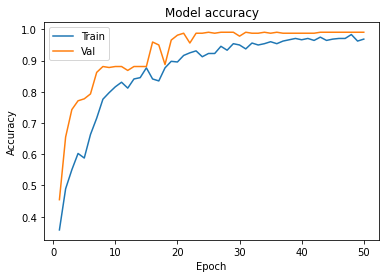

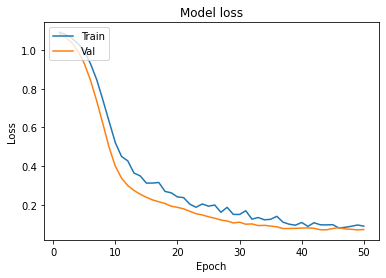

C:\Users\wiki\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


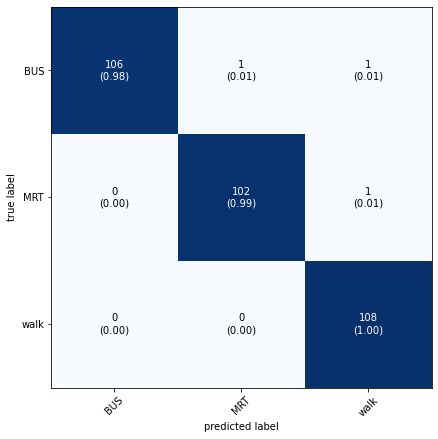

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout ,MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import csv
import scipy.stats as stats

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from decimal import Decimal

processedList = []
tempi = 0

def get_frames(df):
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0, len(df),1):
        x = df['x'].values[i]
        y = df['y'].values[i]
        z = df['z'].values[i]
        label = stats.mode(df['label'][i:i+1])[0][0]
        frames.append([x, y, z])
        labels.append(label)
    frames = np.asarray(frames).reshape(-1, 1, N_FEATURES)
    labels = np.asarray(labels)
    return frames, labels

def plot_learningCurve(history, epochs):
      # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
    
     # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
    
    
with open("data.csv", "r") as f:
    for line in f:
        sepline = line.split(",")
        sepline[4] = sepline[4].replace("\n","")
        if tempi == 0:
            tempi = 1
            continue
        temp = [sepline[0], sepline[1], sepline[2], sepline[3],sepline[4]]
        processedList.append(temp)
        
columns = ['x', 'y', 'z','Tf','label']
data = pd.DataFrame(data = processedList, columns = columns)

data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

activities = data['label'].value_counts().index
df = data.drop(['Tf'], axis = 1).copy()
walk = df[df['label']=='walk'].copy()
BUS = df[df['label']=='BUS'].copy()
MRT = df[df['label']=='MRT'].copy()

balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([walk, BUS, MRT])

label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['label'])
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values
X, y  = get_frames(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0, stratify = y)
X_train = X_train.reshape(478, 1, 3, 1)
X_test = X_test.reshape(319, 1, 3, 1)
model = Sequential()
model.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = X_train[0].shape,padding='same'))
model.add(Dropout(0.1))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size = (3,3),padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

epo = 50
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = 100, epochs = epo, validation_data= (X_test, y_test), verbose=1)

plot_learningCurve(history, epo)

y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test, y_pred)
model.save('model.h5')
plot_confusion_matrix(conf_mat = mat, class_names = label.classes_, show_normed=True, figsize=(7,7))
plt.show()
# Saving model

NameError: name 'plot_confusion_matrix' is not defined